In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr, gdal

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import MaxPooling2D
from keras.layers import Input, Activation, Dense, Flatten, Dropout, concatenate, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# root_path will be used to store trained models

from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
# Downloading the dataset and unpacking it.
# 6 files: Test_Image.tif, Test_DSM.tif, Test_Reference.tif, Train1_Image.tif, Train1_DSM.tif, Train1_Reference.tif, Train2_Image.tif, Train2_DSM.tif, Train2_Reference.tif

!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part2.rar
!wget https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part3.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part1.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part2.rar
!unrar e Images_Semantic_Segmentatio_Assignment.part3.rar

--2023-07-18 12:05:14--  https://github.com/gilson-costa/files/raw/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar [following]
--2023-07-18 12:05:14--  https://raw.githubusercontent.com/gilson-costa/files/main/Images_Semantic_Segmentatio_Assignment.part1.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘Images_Semantic_Segmentatio_Assignment.part1.rar’

Images_Semantic_Seg 100%[===================>]  24.00M   140MB/

In [ ]:
# Functions
def load_DSM_image(image):
  ds = gdal.Open(image)
  img = ds.GetRasterBand(1).ReadAsArray()
  return img

def load_tiff_image(image):
  gdal_header = gdal.Open(image)
  img_gdal = gdal_header.ReadAsArray()
  img = np.transpose(img_gdal, (1,2,0))
  return img

def normalizationDSM(image):
  image_reshaped = image.reshape(image.shape[0],image.shape[1])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1])
  return image_normalized

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

In [ ]:
# Loading and normalizing images
import numpy as np
reference_train1 = load_tiff_image('Train1_Reference.tif')
reference_train1 = np.delete(reference_train1, [1903,1904,
                                                1905, 1906, 1907, 1908,
                                                1909, 1910, 1911, 1912,
                                                1913, 1914, 1915, 1916,
                                                1917, 1918], 1)

reference_train2 = load_tiff_image('Train2_Reference.tif')
reference_train = np.concatenate((reference_train1, reference_train2), axis=0)

image_train1 = load_tiff_image('Train1_Image.tif')
image_train1 = np.delete(image_train1, [1903,1904,
                                        1905, 1906, 1907, 1908,
                                        1909, 1910, 1911, 1912,
                                        1913, 1914, 1915, 1916,
                                        1917, 1918], 1)
image_train2 = load_tiff_image('Train2_Image.tif')
image_train = np.concatenate((image_train1, image_train2), axis=0)
image_train = normalization(image_train)

Train1_DSM = load_DSM_image('Train1_DSM.tif')
Train1_DSM = np.delete(Train1_DSM, [1903,1904,
                                    1905, 1906, 1907, 1908,
                                    1909, 1910, 1911, 1912,
                                    1913, 1914, 1915, 1916,
                                    1917, 1918], 1)
Train2_DSM = load_DSM_image('Train2_DSM.tif')

Train_DSM = np.concatenate((Train1_DSM, Train2_DSM), axis=0)
Train_DSM = normalizationDSM(Train_DSM)

image_train = np.dstack((image_train, Train_DSM))

reference_test = load_tiff_image('Test_Reference.tif')

Test_DSM = load_DSM_image('Test_DSM.tif')
# Normalizes testing image (pixel values from 0 to 1)
Test_DSM = normalizationDSM(Test_DSM)

image_test = load_tiff_image('Test_Image.tif')
# Normalizes testing image (pixel values from 0 to 1)
image_test = normalization(image_test)

image_test = np.dstack((image_test, Test_DSM))



In [ ]:
# Defining number of classes and class indices in relation to reference images (RGB)

num_classes = 5
color2label = {
    (255, 255, 255) : 0,  # Impervious surfaces
    (0,   255, 255) : 1,  # Low vegetation
    (0,     0, 255) : 2,  # Building
    (0,   255,   0) : 3,  # Tree
    (255, 255,   0) : 4   # Car
}

def create_label_image(rgb_image):
  W = np.power(256, [[0],[1],[2]])
  img_index = rgb_image.dot(W).squeeze(-1)
  values = np.unique(img_index)
  label_image = np.zeros(img_index.shape)
  for i, c in enumerate(values):
    try:
      label_image[img_index==c] = color2label[tuple(rgb_image[img_index==c][0])]
    except:
      pass
  return label_image

In [ ]:
# Tranforming regerence RGB images into label images

labels_train = create_label_image(reference_train)
print(labels_train.shape)
labels_test = create_label_image(reference_test)
print(labels_test.shape)

(5111, 1903)
(2558, 2818)


In [ ]:
# Constants and functions

# patch_size defines the measures (spatial dimensions) of the patch.
# Working with square patches (H = W). Therefore, a scalar variable is enough.
patch_size = 256

# patch_stride determine the position of the next patch.
# A patch_stride smaller than the spatial dimension of the patch determines an overlapping.
# 25% ​​overlap between patches.
patch_stride = patch_size - (patch_size // 4)

# channels of the image/patches to be segmented
image_channels = 4

# shape of the input to the network (training)
input_shape = Input((patch_size, patch_size, image_channels))
# Function: extract_patches
# -------------------------
# Extract patches from the original and reference image
#
# Input parameters:
#   image      = array containing the original image (h,w,c)
#   reference  = array containing the reference image (h,w,c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride     = displacement to be applied.
#   border_patches = include patches overlaping image borders
#
# Returns:
#   A, B = List containing the patches for the input image (A) and respective reference (B).
#
def extract_patches(image, reference, patch_size, stride, border_patches=False):
    print("Image dimensions:", image.shape)
    print("Reference dimensions:", reference.shape)
    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
            #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ):
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )
            elif border_patches:
                border_patch_img = np.zeros((patch_size,patch_size,image_channels))
                border_patch_ref = np.zeros((patch_size,patch_size))
                if (m*stride+patch_size > image.shape[0]):
                  border_mmax = patch_size-(m*stride+patch_size-image.shape[0])
                else:
                  border_mmax = patch_size-1
                if (n*stride+patch_size > image.shape[1]):
                  border_nmax = patch_size-(n*stride+patch_size-image.shape[1])
                else:
                  border_nmax = patch_size-1

                border_patch_img[0:border_mmax,0:border_nmax,:] = image[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax,:]
                border_patch_ref[0:border_mmax,0:border_nmax] = reference[m*stride:m*stride+border_mmax,n*stride:n*stride+border_nmax]
                patch_img.append( border_patch_img )
                patch_ref.append( border_patch_ref )

    return np.array(patch_img), np.array(patch_ref)

In [ ]:
# Extracting training patches

x_patches, y_patches = extract_patches(image_train, labels_train, patch_size, patch_stride)

# Transform y_patches, shape (N, H, W) into shape (N, H, W, C). Necessary for data agumentation.
y_patches = np.expand_dims(y_patches, 3)

print( "Number of patches: %d %s " % ( x_patches.shape[0], x_patches.shape[1:] ) )
print( "Number of labeled references: %d %s " % ( y_patches.shape[0], y_patches.shape[1:] ) )

Image dimensions: (5111, 1903, 4)
Reference dimensions: (5111, 1903)
Number of patches: 234 (256, 256, 4) 
Number of labeled references: 234 (256, 256, 1) 


In [ ]:
# Defining the percentage of the training set to be used as validation
valid_percent = 0.2

# Calculating the boundary (index) between training set and validation.
# The premise is always that X and Y have the same number of elements.
limit = len(x_patches) - int( len(x_patches)*valid_percent )

# Building a list of indexes from 0 to N, where N corresponds to the number of images (patches).
indexes = [i for i in range(x_patches.shape[0])]

# Generating randomness in the list
import random
random.shuffle(indexes)

# Indexes of the images that will be used for training
indexes_for_train = indexes[:limit]
# ndexes of the images that will be used for validation
indexes_for_valid = indexes[limit:]

# Training set
x_train = x_patches[indexes_for_train]
y_train = y_patches[indexes_for_train]

# Validation set
x_valid = x_patches[indexes_for_valid]
y_valid = y_patches[indexes_for_valid]

print( "Número de imagens no conjunto de treinamento: %d " % ( len(x_train) ) )
print( "Número de imagens no conjunto de validação: %d " % ( len(x_valid) ) )

# Freeing up memory
x_patches = 0
y_patches = 0

Número de imagens no conjunto de treinamento: 188 
Número de imagens no conjunto de validação: 46 


In [ ]:
# Setting data augmentation tranformations and creating data generators

# Only rotations by 90 degrees
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

# Tranformations for image patches
datagen_args_x = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        # brightness_range=[0.8,1.2], # brightness
        fill_mode='constant',
        cval=0
)

# Transformations for reference patches
datagen_args_y = dict(
        # rotation_range=90, # rotation
        # width_shift_range=0.15, # horizontal shift
        # height_shift_range=0.15, # vertical shift
        # zoom_range=0.25, # zoom
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        fill_mode='constant',
        cval=0
)

# Its necessary to provide the same seed and kwargs to the flow method (images and references)
seed = 1
x_datagen = ImageDataGenerator(**datagen_args_x)
y_datagen = ImageDataGenerator(**datagen_args_y)

In [ ]:
import tensorflow as tf
import math
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import  BatchNormalization
from keras.layers import Reshape, Permute
from keras.layers.convolutional import Convolution2D

def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, tf.zeros_like(out)], i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out


def pool(value, name='pool'):
    """Downsampling operation.
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, d0/2, d1/2, ..., dn/2, ch]
    """
    with tf.name_scope(name) as scope:
        #sh = value.get_shape().as_list()
        sh = list(np.shape(value))
        out = value
        for sh_i in sh[1:-1]:
            assert sh_i % 2 == 0
        for i in range(len(sh[1:-1])):
            out = tf.reshape(out, (-1, 2, np.prod(sh[i + 2:])))
            out = out[:, 0, :]
        out_size = [-1] + [math.ceil(s / 2) for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

def SegNet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder

    inputs = input_shape
    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    #pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)
    pool_1 = pool(conv_2)
    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    #pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)
    pool_2 = pool(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    #pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)
    pool_3 = pool(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    #pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)
    pool_4 = pool(conv_10)
    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    #pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    pool_5 = pool(conv_13)
    # decoder

    #unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    unpool_1 = unpool(pool_5)

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    #unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])
    unpool_2 = unpool(conv_16)
    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    #unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])
    unpool_3 = unpool(conv_19)

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    #unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])
    unpool_4 = unpool(conv_22)

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    #unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])
    unpool_5 = unpool(conv_24)
    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Reshape((256,256,n_labels))(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

def MyNet(input_shape, n_classes):
    # U-Net customizada
    pool_size=(2, 2)
    input_img = input_shape
    output_mode="softmax"

    # Define the layers here...
    # Contract stage
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)

#    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(c2)
    pool_1 = pool(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    #pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(c4)
    pool_2 = pool(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    #pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(c7)
    pool_3 = pool(c7)

    c8 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_3)
    c9 = Conv2D(512, (3, 3), activation='relu', padding='same')(c8)
    c10 = Conv2D(512, (3, 3), activation='relu',padding='same')(c9)

    #pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(c10)
    pool_4 = pool(c10)

    c11 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
    c12 = Conv2D(512, (3, 3), activation='relu', padding='same')(c11)
    c13 = Conv2D(512, (3, 3), activation='relu', padding='same')(c12)

    #pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(c13)
    pool_5 = pool(c13)

    # decoder
    #unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])
    unpool_1 = unpool(pool_5)

    c14 = Conv2D(512, (3, 3), activation='relu', padding='same')(unpool_1)
    c15 = Conv2D(512, (3, 3), activation='relu', padding='same')(c14)
    c16 = Conv2D(512, (3, 3), activation='relu', padding='same')(c15)

    #unpool_2 = MaxUnpooling2D(pool_size)([c16, mask_4])
    unpool_2 = unpool(c16)

    c17 = Conv2D(512, (3, 3), activation='relu', padding='same')(unpool_2)
    c18 = Conv2D(512, (3, 3), activation='relu', padding='same')(c17)
    c19 = Conv2D(256, (3, 3), activation='relu', padding='same')(c18)

    #unpool_3 = MaxUnpooling2D(pool_size)([c19, mask_3])
    unpool_3 = unpool(c19)

    c20 = Conv2D(256, (3, 3), activation='relu', padding='same')(unpool_3)
    c21 = Conv2D(256, (3, 3), activation='relu', padding='same')(c20)
    c22 = Conv2D(128, (3, 3), activation='relu', padding='same')(c21)

    #unpool_4 = MaxUnpooling2D(pool_size)([c22, mask_2])
    unpool_4 = unpool(c22)

    c23 = Conv2D(128, (3, 3), activation='relu', padding='same')(unpool_4)
    c24 = Conv2D(64, (3, 3), activation='relu', padding='same')(c23)

    #unpool_5 = MaxUnpooling2D(pool_size)([c24, mask_1])
    unpool_5 = unpool(c24)
    c25 = Conv2D(64, (3, 3), activation='relu', padding='same')( unpool_5)
    c26 = Conv2D( n_classes, (1, 1), padding='valid')(c25) #""
    c26 = Reshape((256,256,n_classes))(c26)
    outputs = Activation(output_mode)(c26)

    model = Model(inputs=input_img, outputs=outputs, name="MyNet")

    return model

def unet(input_shape, n_classes):
    # U-Net architecture

    input_img = input_shape

    # Define the layers here...
    # Contract stage
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(input_img)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
               padding='same')(c1)
    p1 = MaxPool2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c3)
    p2 = MaxPool2D((2, 2))(c4)

    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c6)
    p3 = MaxPool2D((2, 2))(c7)

    c9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c10 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c9)
    c11 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c10)


    # Expansion stage
    u12 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c11)
    u12 = concatenate([u12, c7])
    c12 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                 padding='same')(u12)
    c13 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                 padding='same')(c12)

    u14 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c13)
    u14 = concatenate([u14, c4], axis=3)
    c14 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u14)

    c15 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c14)

    u16 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c15)
    u16 = concatenate([u16, c2], axis=3)
    c16 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u16)
    c17 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                 padding='same')(c16)
    # Output segmentation

    output = Conv2D(n_classes, (1, 1), activation='softmax')(c17)


    output = Conv2D(n_classes, (1, 1), activation='softmax')(c17)
    return Model(inputs = input_img, outputs = output, name='U-Net')


In [ ]:
# Building the model
model = MyNet(input_shape, num_classes)
#model = SegNet(input_shape, num_classes)
#model.summary()

In [ ]:
# Functions for training

def set_number_of_batches(qt_train_samples, qt_valid_samples, batch_size, data_augmentation, number_samples_for_generator=6):
    if data_augmentation:
        train_batchs_qtd = qt_train_samples//number_samples_for_generator
        valid_batchs_qtd = qt_valid_samples//number_samples_for_generator
    else:
        train_batchs_qtd = qt_train_samples//batch_size
        valid_batchs_qtd = qt_valid_samples//batch_size

    return train_batchs_qtd, valid_batchs_qtd

def get_batch_samples(x, y, batch, batch_size, data_augmentation, number_samples_for_generator):
    if data_augmentation:
        x_batch = x[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]
        y_batch = y[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]

        x_iterator = x_datagen.flow(x_batch, seed=batch)
        y_iterator = y_datagen.flow(y_batch, seed=batch)

        x_batch = np.array([next(x_iterator)[0] for _ in range(batch_size)])
        y_batch = np.array([next(y_iterator)[0] for _ in range(batch_size)])
    else:
        x_batch = x[batch * batch_size : (batch + 1) * batch_size, : , : , :]
        y_batch = y[batch * batch_size : (batch + 1) * batch_size, : , : , :]

    return x_batch, y_batch

def train_unet(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, filepath, filename, data_augmentation=False, number_samples_for_generator=1):
    print('Start the training...')

    # calculating number of batches
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], x_valid.shape[0], batch_size, data_augmentation, number_samples_for_generator)

    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        print('Start epoch ... %d ' %(epoch) )
        # shuffle train set
        x_train, y_train = shuffle(x_train , y_train, random_state = 0)

        # TRAINING
        train_loss = np.zeros((1 , 2))
        # mini batches strategy
        #for  batch in range(train_batchs_qtd):
        for  batch in range(batch_size):
            print('Start batch ... %d ' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, y_train, batch, batch_size, data_augmentation, number_samples_for_generator)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_batch)

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd

        # VALIDATING
        valid_loss = np.zeros((1 , 2))
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, batch_size, data_augmentation, number_samples_for_generator)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_batch)

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd

        # Showing the results.
        print("%d [training loss: %f , Train acc.: %.2f%%][Test loss: %f , Test acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]


In [ ]:
# Defining hyperparameters for training

batch_size = 16
epochs = 15

# Fixed class weights: [Impervious surfaces, Low vegetation, Building, Tree, Car]
class_weights = [0.10, 0.10, 0.10 , 0.10, 0.5]

# Early stoping parameters
early_stopping_epochs = 10
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%

data_augmentation = True
number_samples_for_generator = 4

# optimizer
adam = Adam(learning_rate = 0.0001 , beta_1=0.9)

In [ ]:
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Compile the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer=adam , metrics=['accuracy'], loss_weights=class_weights)

# Train the model
best_model_filename = 'best_CNN_model'
es = callbacks.EarlyStopping(monitor="val_loss",
                                           mode="min", patience=5,
                                           restore_best_weights=True)
#history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
#                        epochs=10, batch_size=8,
#                        verbose=2, callbacks=[es])
#epochs=5
#batch_size=8
history = train_unet(model, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)
# Uncomment the line above for training with the whole dataset!!!
#history = train_unet(model, x_train[0:64], y_train[0:64], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, best_model_filename, data_augmentation, number_samples_for_generator)


Start the training...
Start epoch ... 0 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start batch ... 4 
Start batch ... 5 
Start batch ... 6 
Start batch ... 7 
Start batch ... 8 
Start batch ... 9 
Start batch ... 10 
Start batch ... 11 
Start batch ... 12 
Start batch ... 13 
Start batch ... 14 
Start batch ... 15 
0 [training loss: 0.054752 , Train acc.: 9.20%][Test loss: 0.160706 , Test acc.:33.96%]
Saving the model...
Start epoch ... 1 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start batch ... 4 
Start batch ... 5 
Start batch ... 6 
Start batch ... 7 
Start batch ... 8 
Start batch ... 9 
Start batch ... 10 
Start batch ... 11 
Start batch ... 12 
Start batch ... 13 
Start batch ... 14 
Start batch ... 15 
1 [training loss: 0.054640 , Train acc.: 12.18%][Test loss: 0.160264 , Test acc.:33.96%]
Saving the model...
Start epoch ... 2 
Start batch ... 0 
Start batch ... 1 
Start batch ... 2 
Start batch ... 3 
Start ba

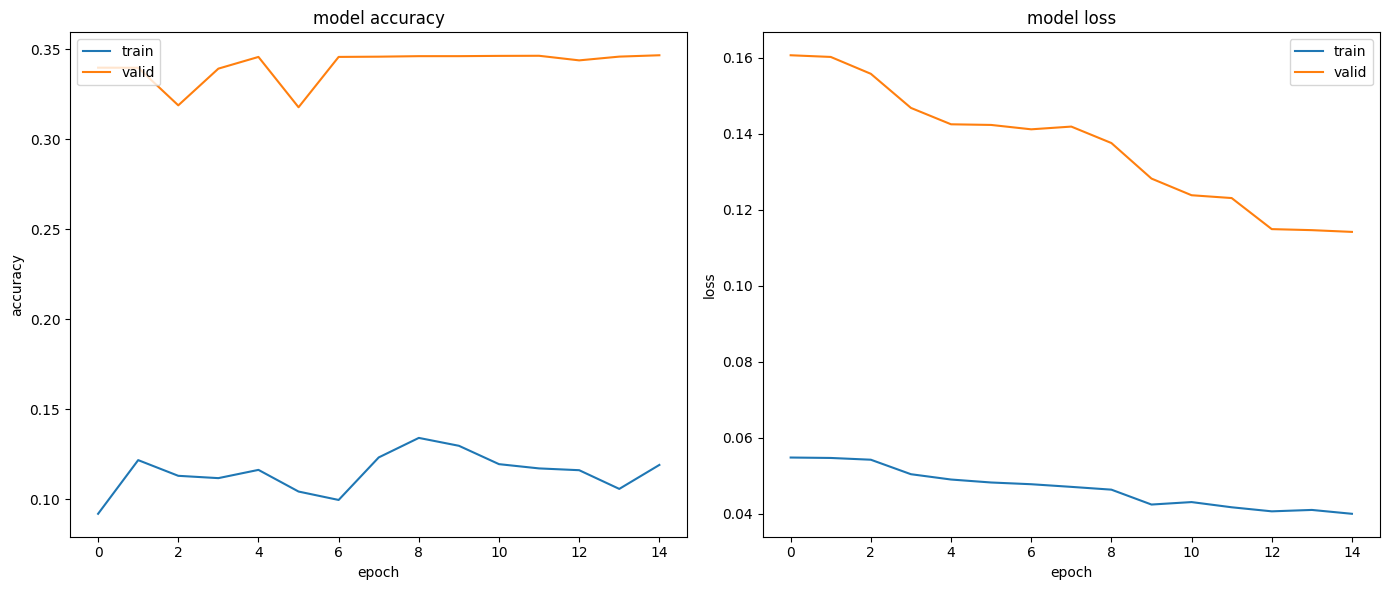

In [ ]:
# Functions

def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):

        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

show_graph_loss_accuracy(np.asarray(history),1)

In [ ]:
# Functions

def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_classes = np.argmax(result, axis=-1)
    return predicted_classes

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

# Nova seção

In [ ]:
#load the best model (.h5 file)
model = load_model(root_path + best_model_filename + '.h5', compile=False)

# Test the model over training and validation data
pred_train = Test(model, x_train)
pred_valid = Test(model, x_valid)

2/2 [==============================] - 76s 22s/step


In [ ]:
# Showing the confusion matrix and accuracy metrics for the training data

true_labels = np.reshape(y_train, (y_train.shape[0]* y_train.shape[1]*y_train.shape[2]))
predicted_labels = np.reshape(pred_train, (pred_train.shape[0]* pred_train.shape[1]*pred_train.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[   5327    4306    1377 3216725       0]
 [    982    6407     174 2214845       0]
 [   4925    3251    1254 2544505       0]
 [    624   12990      99 4244530       0]
 [     86      45      18   58298       0]]

Metrics
Accuracy:  34.555621857338764
F1score:  [ 0.32885974  0.56966125  0.09808918 51.33328326  0.        ]
Recall:  [1.65038332e-01 2.88290899e-01 4.91007015e-02 9.96779658e+01
 0.00000000e+00]
Precision:  [44.59979906 23.73050854 42.91581109 34.56766455  0.        ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final